# Wikipedia Racing Agent

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JudgmentLabs/judgment-cookbook/blob/refactor/Wikipedia_Racing_Agent.ipynb)
[![Docs](https://img.shields.io/badge/Documentation-blue)](https://docs.judgmentlabs.ai/documentation)

In this notebook, you will be using [`judgeval`](https://github.com/JudgmentLabs/judgeval) together with [Fireworks AI](https://fireworks.ai/) to train your own Wikiracer agent from scratch! This guide shows how to integrate judgeval's multi-turn RL training module with a Python agent, using just a few lines of instrumentation on top of the base agent.

Beginning with a Qwen 2.5 7B base model, you will train the agent to play Wikiracer, a game where you have to traverse from one Wikipedia page to another as fast as possible. For example, you may have to get from the Virus page to the European Commission page by clicking on Dmitri Ivanovsky to Poland and so on.

You will instrument a simple agent environment, reward function, and instrument existing Wikiracing agent code with Judgeval's RL training module. The trainer will route to Fireworks' RFT endpoint to execute a hosted training loop so you don't have to orchestrate data pipelines or manage compute infrastructure!


TODO add image here of fireworks api key

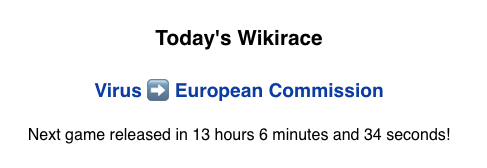

In [ ]:
# Installations
!pip install wikipedia requests python-dotenv judgeval
!pip install --upgrade fireworks-ai


## Setup

You can get your Judgment API key and Org ID for free on [Judgment](https://app.judgmentlabs.ai/register).

![Get Started](./assets/get_started.png)

Within your organization, create a project called `wikipedia-racing-small`.


**Fireworks AI**

You will also need a Fireworks AI account to train your agent with. You can sign up for free at [Fireworks AI](https://app.fireworks.ai/) and receive $X in credits to run your first experiments! Make sure to save your `FIREWORKS_API_KEY`.

![FIREWORKS API KEY](./assets/fireworks_api_key.png)

In [ ]:
# set api keys
import os
from dotenv import load_dotenv

os.environ["JUDGMENT_API_KEY"] = ...  # Fill your API keys here
os.environ["JUDGMENT_ORG_ID"] = ... 
os.environ["FIREWORKS_API_KEY"] = ... 

load_dotenv()

### Agent Environment Setup

For the agent to play Wikiracer, we need it to have access to select and follow different links. To do this, we will use the [Wikipedia API](https://en.wikipedia.org/w/api.php) to traverse the various pages our agent will visit.

For the purpose of Wikiracing, we will also augment the agent's environment by cutting out types of links that are not useful for Wikiracing, such as metadata links and we will prioritize important types of links such as locations. This helps simulate what a human sees on an actual Wikipedia page.

In [8]:
# wikipedia helper functions
def get_wikipedia_links(page_title: str) -> list:
    """Get all links from a Wikipedia page"""
    url = "https://en.wikipedia.org/w/api.php"

    headers = {
        'User-Agent': 'WikipediaRacingBot/1.0 (https://example.com/contact) requests/2.28.1'
    }

    params = {
        'action': 'query',
        'format': 'json',
        'titles': page_title,
        'prop': 'links',
        'pllimit': 'max'
    }

    try:
        response = requests.get(url, params=params, headers=headers)
        data = response.json()

        pages = data['query']['pages']
        page_id = list(pages.keys())[0]

        if page_id == '-1':
            return []

        links = pages[page_id].get('links', [])
        link_titles = [link['title'] for link in links]
        return link_titles

    except Exception as e:
        print(f"Error: {e}")
        return []

def filter_available_links(links, visited_pages, target_page=None):
    filtered = []

    for link in links:
        # Skip visited pages
        if link in visited_pages:
            continue

        # Skip meta/technical links
        skip_patterns = [
            'wikipedia:', 'category:', 'template:', 'file:', 'help:',
            '(disambiguation)', 'list of', 'timeline of', 'history of'
        ]
        if any(pattern in link.lower() for pattern in skip_patterns):
            continue

        # unlikely we want a specific event. It's easier to hardcode some of this out to keep the agent focused on broaded link clicks
        if any(year in link for year in ['1999', '2000', '2001', '2002', '2003', '2004', '2005']):
            continue

        if len(link.split()) > 4:
            continue

        filtered.append(link)

    if target_page:
        filtered = rank_links_by_relevance(filtered, target_page)
    else:
        # If no target, at least deprioritize numbered/address links
        filtered = deprioritize_bad_links(filtered)

    return filtered[:15]  # Return top 15

def rank_links_by_relevance(links, target_page):
    # rank by relevancy
    target_lower = target_page.lower()

    def relevance_score(link):
        link_lower = link.lower()
        score = 0

        # Exact match gets highest score
        if link_lower == target_lower:
            return 1000

        # Partial matches
        if target_lower in link_lower or link_lower in target_lower:
            score += 100

        # Geographic targets - prioritize location-related links
        if any(geo_term in target_lower for geo_term in ['california', 'mountain view', 'seattle', 'chicago']):
            if any(geo_word in link_lower for geo_word in ['city', 'county', 'state', 'california', 'united states', 'geography']):
                score += 50

        # Company targets - prioritize business-related links
        if any(biz_term in target_lower for biz_term in ['apple', 'google', 'microsoft', 'tesla']):
            if any(biz_word in link_lower for biz_word in ['company', 'corporation', 'inc.', 'technology', 'business']):
                score += 50

        # Heavily penalize numbered addresses and technical specs
        if link.split()[0].isdigit():
            score -= 200

        # Penalize very specific technical terms
        if any(tech in link_lower for tech in ['battery', 'protocol', 'specification']):
            score -= 100

        # Boost common conceptual links
        if any(concept in link_lower for concept in ['history', 'culture', 'economy', 'geography']):
            score += 20

        return score

    # Sort by relevance score (highest first)
    return sorted(links, key=relevance_score, reverse=True)

def deprioritize_bad_links(links):
    good_links = []
    bad_links = []

    for link in links:
        # Check if it starts with numbers (addresses, technical specs)
        if link.split()[0].isdigit():
            bad_links.append(link)
        else:
            good_links.append(link)

    # Return good links first, then bad links
    return good_links + bad_links

For training our agent, we'll create a small task dataset of 4 easy examples, 4 medium examples, and 4 harder examples. Feel free to change both the quantity and content of these examples to match your interests and use case!

In [9]:
def create_small_wikipedia_dataset():
    """Create small focused task dataset (16 examples)"""

    small_dataset = [
        # Easy (2-3 hops) - Same domain connections
        {"start_page": "MacBook", "target_page": "Apple Inc.", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "iPhone", "target_page": "California", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Albert Einstein", "target_page": "Germany", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Pizza", "target_page": "Italy", "max_clicks": 4, "difficulty": "easy"},

        # Medium (4-5 hops) - Cross category but logical
        {"start_page": "MacBook", "target_page": "California", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Google", "target_page": "Mountain View", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Tesla, Inc.", "target_page": "Elon Musk", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Microsoft", "target_page": "Seattle", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Albert Einstein", "target_page": "Physics", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Barack Obama", "target_page": "Chicago", "max_clicks": 6, "difficulty": "medium"},

        # Hard (6+ hops) - Very different domains
        {"start_page": "MacBook", "target_page": "Pizza", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Albert Einstein", "target_page": "Basketball", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Google", "target_page": "Coffee", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Python (programming language)", "target_page": "Taylor Swift", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Quantum computing", "target_page": "McDonald's", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Basketball", "target_page": "Philosophy", "max_clicks": 8, "difficulty": "hard"},
    ]

    return small_dataset

wikipedia_small_dataset = create_small_wikipedia_dataset()

wikipedia_training_prompts = [
    {
        "start_page": ex["start_page"],
        "target_page": ex["target_page"],
        "max_clicks": ex["max_clicks"]
    }
    for ex in wikipedia_small_dataset
]

print(f"Created {len(wikipedia_training_prompts)} training examples.")

Created 16 training examples.


With the eventual goal of using RFT on this agent, we need a reward model that produces scores representing how well the Wikiracing agent performed. 

In this case, we define the following scorer which grades a trajectory along three criteria:
1. Points based on if it wins (reaches target page with less than or equal to `max_clicks`)
2. Bonus points if it uses fewer clicks than the `max_clicks`
3. Doesn't repeat or go in circles, and persists towards the task. 

This is a simple reward model, so feel free to change these rewards as you see fit!

In [10]:
from judgeval.scorers.example_scorer import ExampleScorer
from judgeval.data import Example

# TODO please clean this up

class WikipediaRacingScorer(ExampleScorer):
    score_type: str = "WikipediaRacing"

    async def a_score_example(self, example: Example, *args, **kwargs) -> float:
        """
        Takes an `Example` that represents a single trajectory and scores it according to the criteria from above.
        """
        actual_output = example.actual_output  # we store agent result here

        agent_results = None

        if isinstance(actual_output, dict):
            # Agent returned a dict directly
            agent_results = actual_output
            print("Found agent results in actual_output (dict)")
        elif isinstance(actual_output, str):
            # Agent might have returned a JSON string
            try:
                import json
                agent_results = json.loads(actual_output)
                print("Found agent results in actual_output (parsed JSON)")
            except:
                print("actual_output is string but not valid JSON")
                return 0.0
        else:
            print("actual_output is not dict or string")
            return 0.0

        # Extract game data from agent results
        if not isinstance(agent_results, dict):
            print(" Agent results is not a dict")
            return 0.0

        game_won = agent_results.get("game_won", False)
        clicks_used = agent_results.get("clicks_used", 0)
        path_history = agent_results.get("path_history", [])
        max_clicks = agent_results.get("max_clicks", 8)

        print(f" Extracted: Won={game_won}, Clicks={clicks_used}, Path length={len(path_history)}")
        print(f"Path: {' → '.join(path_history) if path_history else 'No path'}")

        # Full reward for winning
        if game_won:
            success_reward = 1.0
            efficiency_reward = max(0.1, 1.0 - (clicks_used - 1) / (max_clicks - 1) * 0.8)
            path_quality = len(set(path_history)) / len(path_history) if path_history else 0
            total_reward = success_reward + (efficiency_reward * 0.3) + (path_quality * 0.2)
            final_score = min(total_reward, 2.0) / 2.0
            print(f"  Full reward: {final_score}")
            return final_score

        # Partial credit for failed games
        partial_score = 0.0

        # Reward for making any progress
        if clicks_used > 0:
            partial_score += 0.15
            print(f"  +0.15 for making moves")

        # Reward for not going in circles
        if len(path_history) > 0:
            unique_ratio = len(set(path_history)) / len(path_history)
            circle_bonus = unique_ratio * 0.2
            partial_score += circle_bonus
            print(f"  +{circle_bonus:.3f} for avoiding circles ({unique_ratio:.2f} unique ratio)")

        # Reward for persistence
        if clicks_used >= 2:
            partial_score += 0.1
            print(f"  +0.1 for multiple moves")

        if clicks_used >= max_clicks - 1:
            partial_score += 0.05
            print(f"  +0.05 for persistence")

        final_partial = min(partial_score, 0.5)
        print(f"  Final partial reward: {final_partial}")
        return final_partial

### Setting Up Our Agent

Now that we have finished constructing the agent environment and reward function, we must construct the agent itself.

The agent code will use a `TrainableModel` from Fireworks, so let's get our model deployed first.

See the screenshot below for Fireworks Deployed Models UI. The `model_id` can be whatever name you specify, `user_id` will be your Fireworks username upon signing up for an account, and `deployment_id` is shown above. In this case it is: `lyha980l-v8-v1jsqktg`.

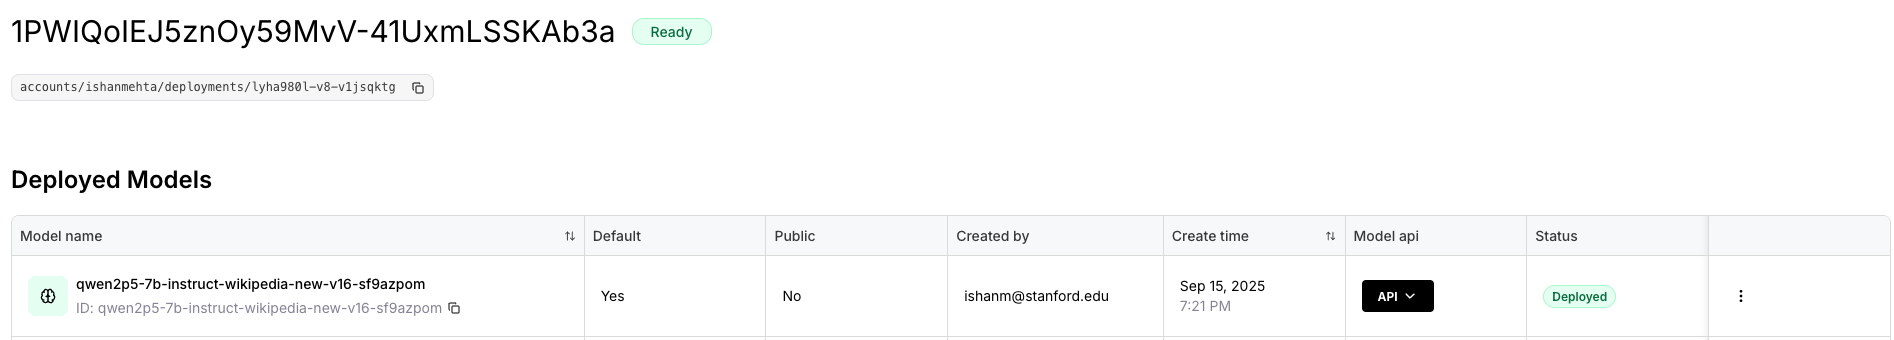

As we write the agent, we will integrate it's model calls and tool calls to set up for our reinforcement learning module.

For more information about Judgment `Tracer`, `wrap()`, and `Example Scorer`, check out these documents:
1. https://docs.judgmentlabs.ai/documentation/tracing/introduction#tracing
2. https://docs.judgmentlabs.ai/documentation/evaluation/scorers/introduction

In order to integrate with our base agent code, we will use the `Tracer` to instrument all function calls with the `@judgment.observe` decorator to collect function metadata, as well as the `wrap()` method that allows us to capture metadata about the LLM (hosted on Fireworks) instrumented with `TrainableModel` and `TrainerConfig`.

To make the instrumentation clearer, any judgeval code will be highlighted in comment blocks outside of the `@judgment.observe` decorators.

In [ ]:
### JUDGEVAL INTEGRATION
model = wrap(TrainableModel(  # LLM that runs our agent
    TrainerConfig(
        base_model_name="qwen2p5-7b-instruct",  # replace this with your own choice
        model_id="qwen2p5-7b-instruct-wikipedia-new",
        user_id="andrewli2403",  # fill in with your information
        deployment_id="lyha980l-v8-v1jsqktg"  # fill in with your information
    )
))

In [14]:
import os
from dotenv import load_dotenv

from judgeval.tracer import Tracer, wrap
from judgeval.trainer import JudgmentTrainer, TrainerConfig
from judgeval.trainer.trainable_model import TrainableModel
from judgeval.trainer.config import TrainerConfig

load_dotenv()

judgment = Tracer(
    project_name="wikipedia-racing-small",
    api_key=os.getenv("JUDGMENT_API_KEY")
)
### END OF JUDGEVAL INTEGRATION

# Create agent instance
# agent_instance = WikipediaRacingAgent()

@judgment.observe(span_type="function")
async def get_model_response(messages: list) -> str:
    """Get a response from the model for the current conversation state."""
    response = await model.chat.completions.acreate(
        messages=messages,
        max_tokens=100,
        temperature=0.7,
        n=1,
    )
    return response.choices[0].message.content.strip()

@judgment.observe(span_type="function")
async def process_navigation_turn(messages: list, current_page: str, target_page: str,
                                available_links: list, click_count: int, max_clicks: int) -> tuple:
    """Process a single navigation turn. Instructs the agent to pick a link to traverse."""

    # Create user prompt for this turn
    links_text = "\n".join([f"- {link}" for link in available_links[:15]])
    user_prompt = f"""Wikipedia Racing Navigation:

Current page: {current_page}
Target page: {target_page}
Clicks used: {click_count}/{max_clicks}

Available links from this page:
{links_text}

Choose ONE link that gets you closer to "{target_page}".
Respond with ONLY the exact link name from the list above."""

    messages.append({"role": "user", "content": user_prompt})
    assistant_response = await get_model_response(messages)

    messages.append({"role": "assistant", "content": assistant_response})

    return messages, assistant_response

@judgment.observe(span_type="function")
async def wikipedia_racing_agent(start_page, target_page, max_clicks, **kwargs):
    """
    Wikipedia racing agent that navigates from start to target page. It returns a
    dict with game results and conversation history
    """

    # Initialize game state
    current_page = start_page
    path_history = [start_page]
    click_count = 0

    # Initialize agent state
    messages = [
        {
            "role": "system",
            "content": f"You are an expert Wikipedia navigator. Your goal is to get from '{start_page}' to '{target_page}' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."
        }
    ]
    responses = []

    # Game loop
    while click_count < max_clicks:
        # Check win condition
        if _normalize_title(current_page) == _normalize_title(target_page):
            break

        # Get available links with relevance ranking
        raw_links = get_wikipedia_links(current_page)
        available_links = filter_available_links(raw_links, path_history, target_page)

        if not available_links:
            break

        messages, assistant_response = await process_navigation_turn(
            messages, current_page, target_page, available_links,
            click_count, max_clicks
        )
        responses.append(assistant_response)

        # Parse and validate choice
        chosen_link = assistant_response.replace("<|im_start|>", "").replace("<|im_end|>", "").strip()

        # Find best match from available links
        valid_choice = None
        for link in available_links:
            if chosen_link.lower() == link.lower() or chosen_link in link:
                valid_choice = link
                break

        if not valid_choice:
            # Fallback to first available link
            valid_choice = available_links[0]

        # Make move
        current_page = valid_choice
        path_history.append(valid_choice)
        click_count += 1

    # Determine success
    game_won = _normalize_title(current_page) == _normalize_title(target_page)

    # Debug logging
    print(f"Agent returning: Won={game_won}, Clicks={click_count}, Path={len(path_history)}")
    print(f"Path: {' → '.join(path_history)}")

    # return in this format so agent/scorers are aligned
    return {
        "messages": messages,
        "responses": responses,
        "start_page": start_page,
        "target_page": target_page,
        "max_clicks": max_clicks,
        "game_won": game_won,
        "clicks_used": click_count,
        "path_history": path_history
    }

def _normalize_title(title):
    return title.lower().strip().replace("_", " ").replace("-", " ")

### Training Loop with Fireworks

Now the magic happens! We simply use the `JudgmentTrainer.train` method and select Fireworks as the RFT compute provider and our agent will train!

Under the hood, each prompt from the `prompts` will be passed to our agent function which produces a rollout. Each rollout will be scored with the `WikipediaRacingScorer` and the rewards will be used to update the model weights according to Fireworks' implementation of GRPO.

In [ ]:
trainer = JudgmentTrainer(
    tracer=judgment,
    project_name="wikipedia-racing-small",
    trainable_model=model,
    config=TrainerConfig(
        base_model_name="qwen2p5-7b-instruct",
        model_id="qwen2p5-7b-instruct-wikipedia-new",
        user_id="andrewli2403",
        deployment_id="lyha980l-v8-v1jsqktg",
        num_steps=16,
        num_prompts_per_step=8,
        num_generations_per_prompt=4
    )
)
await trainer.train(
    agent_function=wikipedia_racing_agent,
    scorers=[WikipediaRacingScorer()],
    prompts=wikipedia_training_prompts,
    rft_provider="fireworks"
)

✅ [Training] Starting reinforcement learning training
✅ [Step 1/16] Starting training step 1
🔄 [Training] Generating 32 rollouts...
Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Tesla, Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1342.61Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Tesla, Inc.
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=287519;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/5480e8c6-58bf-41be-9b7a-875846fc5dbe\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Google


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1697.41Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Google
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=882027;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/2b18978c-1022-4637-8b82-9e1302e358c0\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Pizza


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1371.58Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Pizza
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=671804;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/d311b59f-7b52-45e5-85ee-7f58c3914577\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: iPhone


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 253.42Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: iPhone
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=650688;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/bf1031dd-fe01-4804-b24d-df2b438d6f72\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Pizza


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1788.62Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Pizza
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=55106;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/4bd28dcc-ea50-440c-901b-f2b8ace8adaf\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Tesla, Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1190.55Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Tesla, Inc.
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=683063;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/1271243f-655c-402f-8039-ea595f8b1a9f\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Google


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1121.17Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Google
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=809945;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/0f40112a-fd2e-47c0-90e5-8d4cc2780247\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Pizza


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1331.53Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Pizza
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=379524;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/12b7f3c5-d1c7-4266-93de-0b1145d77799\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1368.45Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=481908;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/938365d2-8702-4f3f-add2-a8b85c99e249\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Google


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1310.31Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Google
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=214104;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/ea317bc3-456d-481d-aeb9-f8052ebe27e4\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Microsoft


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1483.66Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Microsoft
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=87227;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/b4854e9f-edc4-445f-b61d-10a52412bbfb\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1788.62Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=86093;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/254b24dc-361f-4ca6-abbe-b6db66fe2f80\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Albert Einstein


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1597.83Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Albert Einstein
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=994070;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/fcc2d645-a416-4ff7-bf55-7fb6dfacd55d\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 777.01Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=197147;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/1d07236c-1fa6-4987-b9d3-c306cbe353c3\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Albert Einstein


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1479.99Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Albert Einstein
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=36138;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/dd32dc49-b59e-4ec4-ae28-a6981ee54a2f\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Google


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1300.56Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Google
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=25872;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/d6409831-0906-402f-a870-baa5f66a4d22\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Microsoft


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1098.85Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Microsoft
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=277835;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/213fdb42-a870-4c92-8274-af4c04d5aea9\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1117.29Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=182685;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/de009671-dd8c-4599-ab4f-2aec86a65651\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: iPhone


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1752.01Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: iPhone
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=705099;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/de59bf70-bcd6-4c17-855a-6241ddca52d6\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Albert Einstein


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1773.49Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Albert Einstein
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=461611;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/e930de94-92a3-4b62-9748-d29c8fef9a04\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Tesla, Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1592.37Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Tesla, Inc.
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=10335;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/3a2dcf4a-d2e9-4744-98c9-bd2620aa5a4d\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Microsoft


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 2123.70Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Microsoft
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=466797;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/45c35722-d514-41cc-be4f-c3c5a419059d\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1319.38Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=596967;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/14bbac09-0203-44eb-be20-3b31f1cafe12\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: iPhone


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1587.55Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: iPhone
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=696774;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/acd1105d-6aa9-440d-893a-1c7135ddfda1\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1242.76Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=670083;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/69a60b64-c6c9-4c19-befd-b055c1e7fc1e\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Albert Einstein


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1368.01Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Albert Einstein
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=82014;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/3328e50a-ce11-42db-b2ea-5827cc097e49\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Tesla, Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1236.16Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Tesla, Inc.
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=117709;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/205bb69b-005a-48b5-9eeb-f126fab7cc82\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Microsoft


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1191.90Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Microsoft
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=440438;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/498029f5-83af-4d9b-976e-293db06b7969\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1151.96Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=114754;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/93dac486-186b-42ca-84d8-26d1d1c82fea\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: MacBook


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1303.39Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: MacBook
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=419462;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/af5a3a96-a749-4596-bf51-9ee2e58ca52e\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: iPhone


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1060.51Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: iPhone
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=672491;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/5c5bbb12-feee-40ec-95c3-ae9e3c96a019\View Results]8;;\

Error: name 'requests' is not defined
Agent returning: Won=False, Clicks=0, Path=1
Path: Pizza


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1589.96Example/s]

Found agent results in actual_output (dict)
 Extracted: Won=False, Clicks=0, Path length=1
Path: Pizza
  +0.200 for avoiding circles (1.00 unique ratio)
  Final partial reward: 0.2


🔍 You can view your evaluation results here: ]8;id=629558;https://app.judgmentlabs.ai/org/12b03546-81a4-4f6c-b3cf-4670c9b8548e/project/b7a2b9b0-74dd-4c56-8b2d-d25becd973e9/tests/3fe5a13e-a93a-4431-8dc3-2b117c9ba1b6\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 1/16] Preparing training dataset
✅ [Step 1/16] Preparing training dataset - Complete
✅ [Step 1/16] Starting reinforcement training
🔄 [Step 1/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 1/16] Training job in progress - Complete
✅ [Step 1/16] Training completed! New model: accounts/andrewli2403/models/qwen2p5-7b-instruct-wikipedia-new-v1
✅ [Step 2/16] Starting training step 2
🔵 [Model] Creating and deploying model snapshot: accounts/andrewli2403/models/qwen2p5-7b-instruct-wikipedia-new-v1
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...


TODO show trajectories along the way to show how the tracing works to manage jobs as they run

And there you go! It's that easy to create an RFT job from your existing agent code!


# Results

You can see the original task (no RL) is quite tough for the agent and it isn't able to win any games.

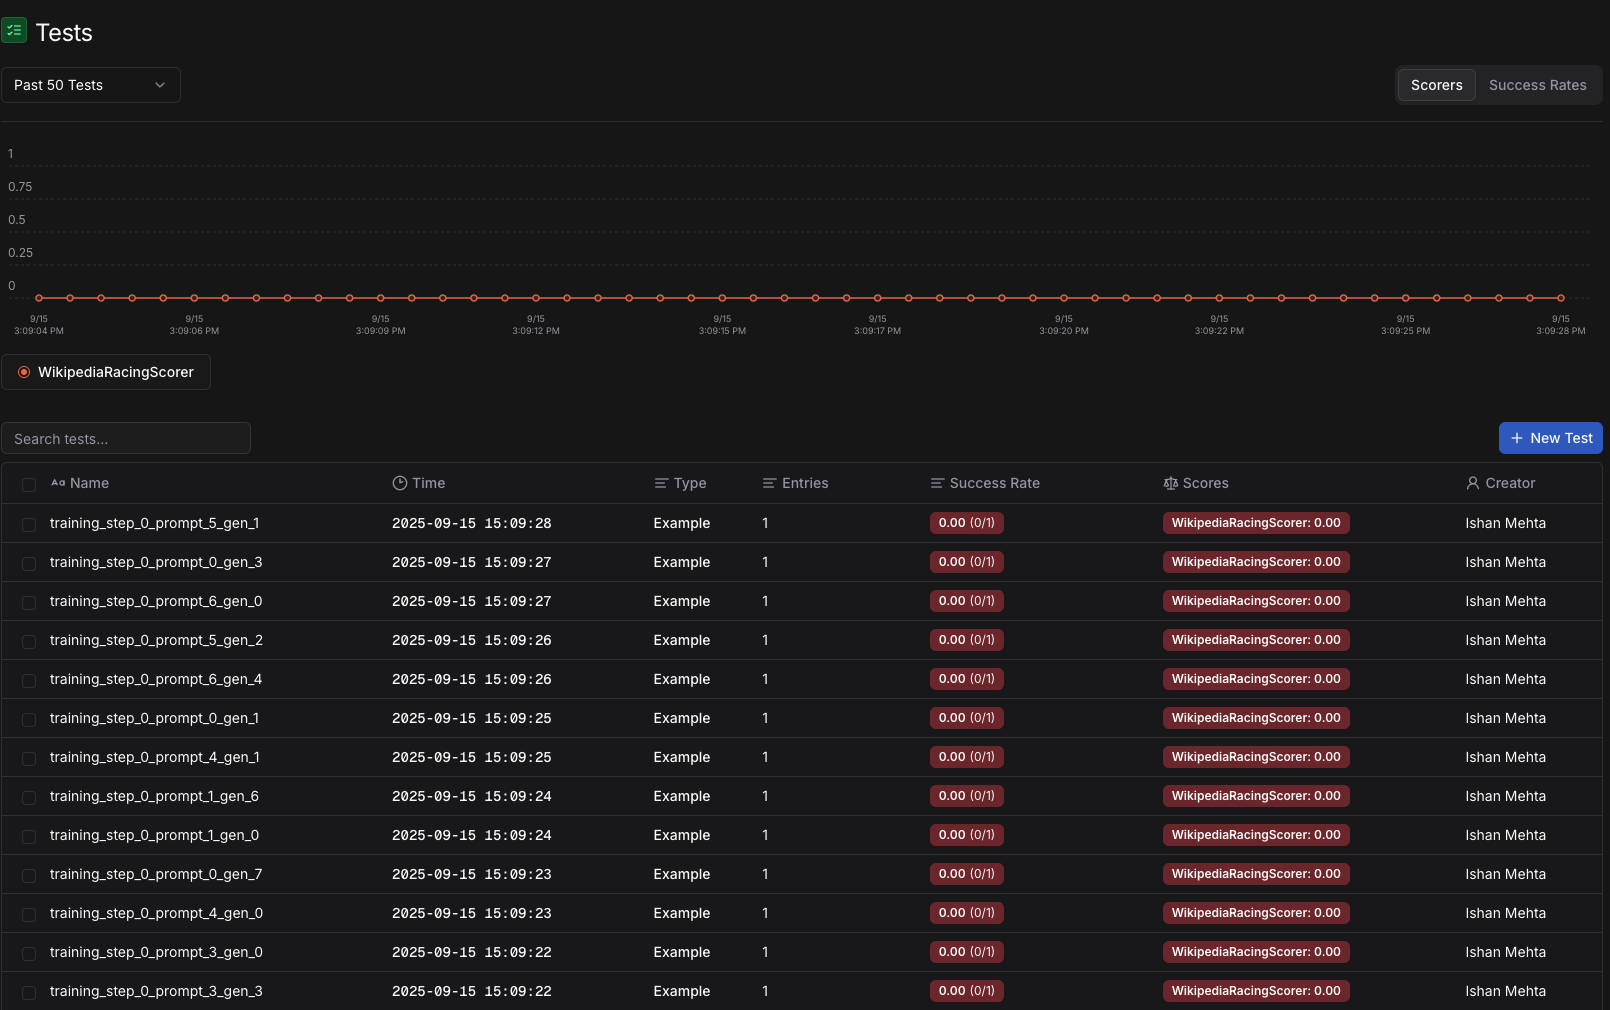

After some training, we can see a bit of improvement. This is when we began the RFT job. 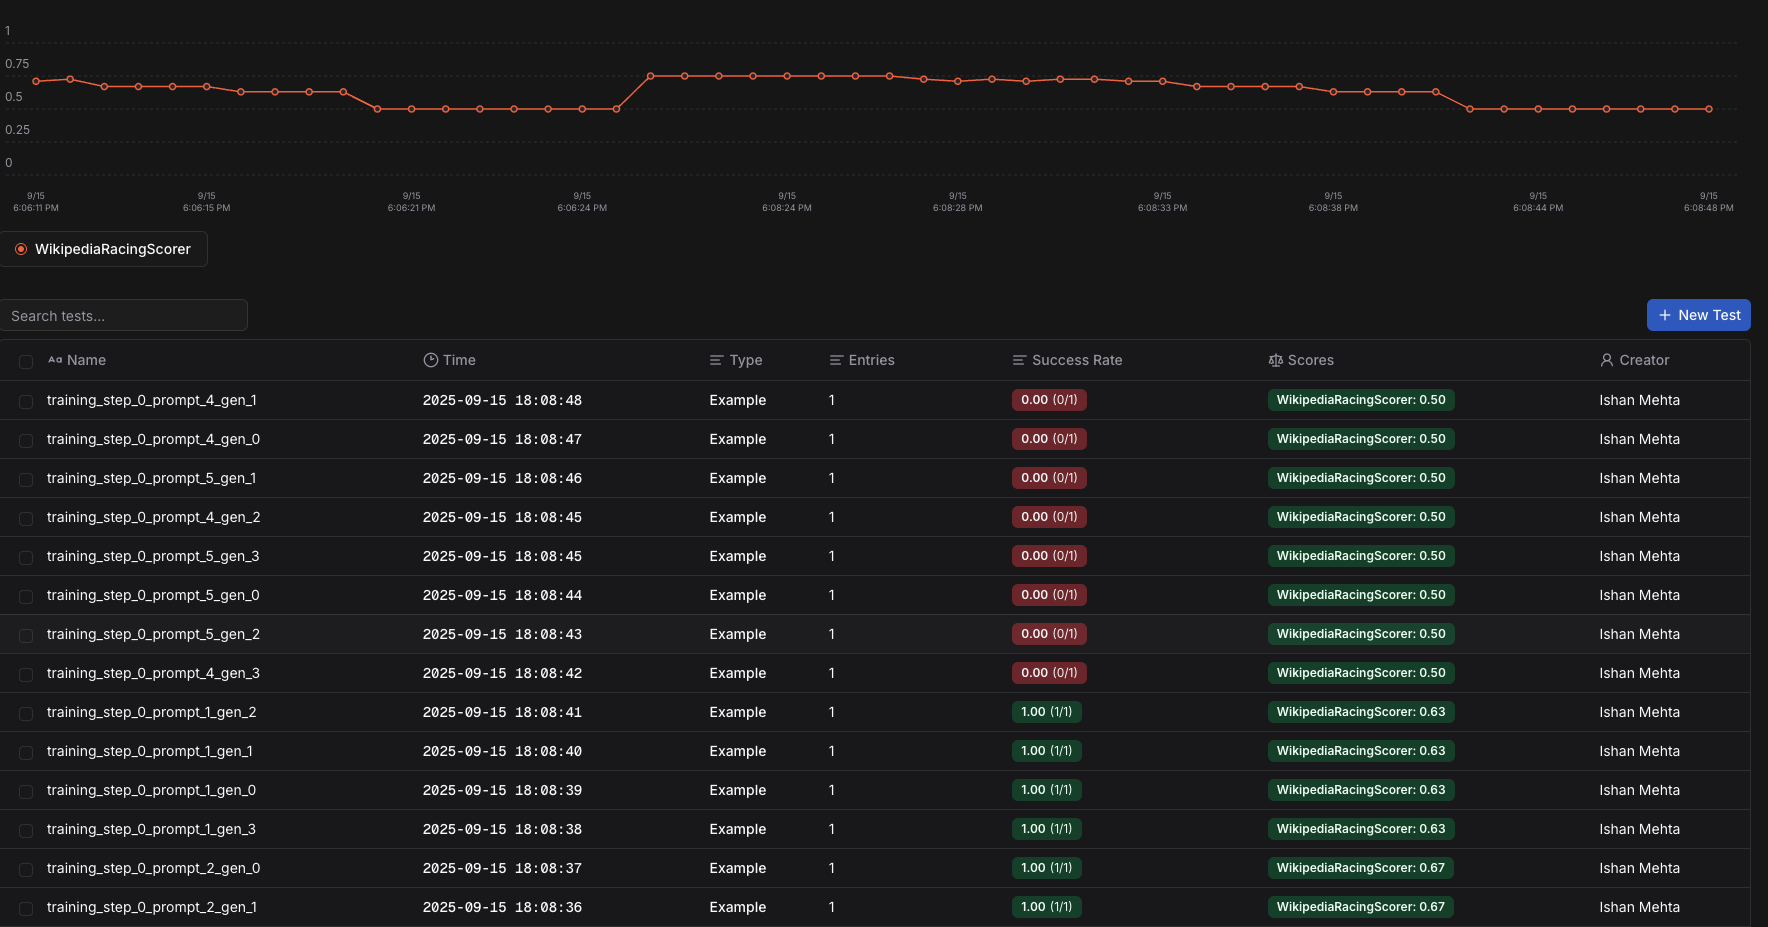

This is a bar-chart view from the Judgment UI that shows our intermediate progress. 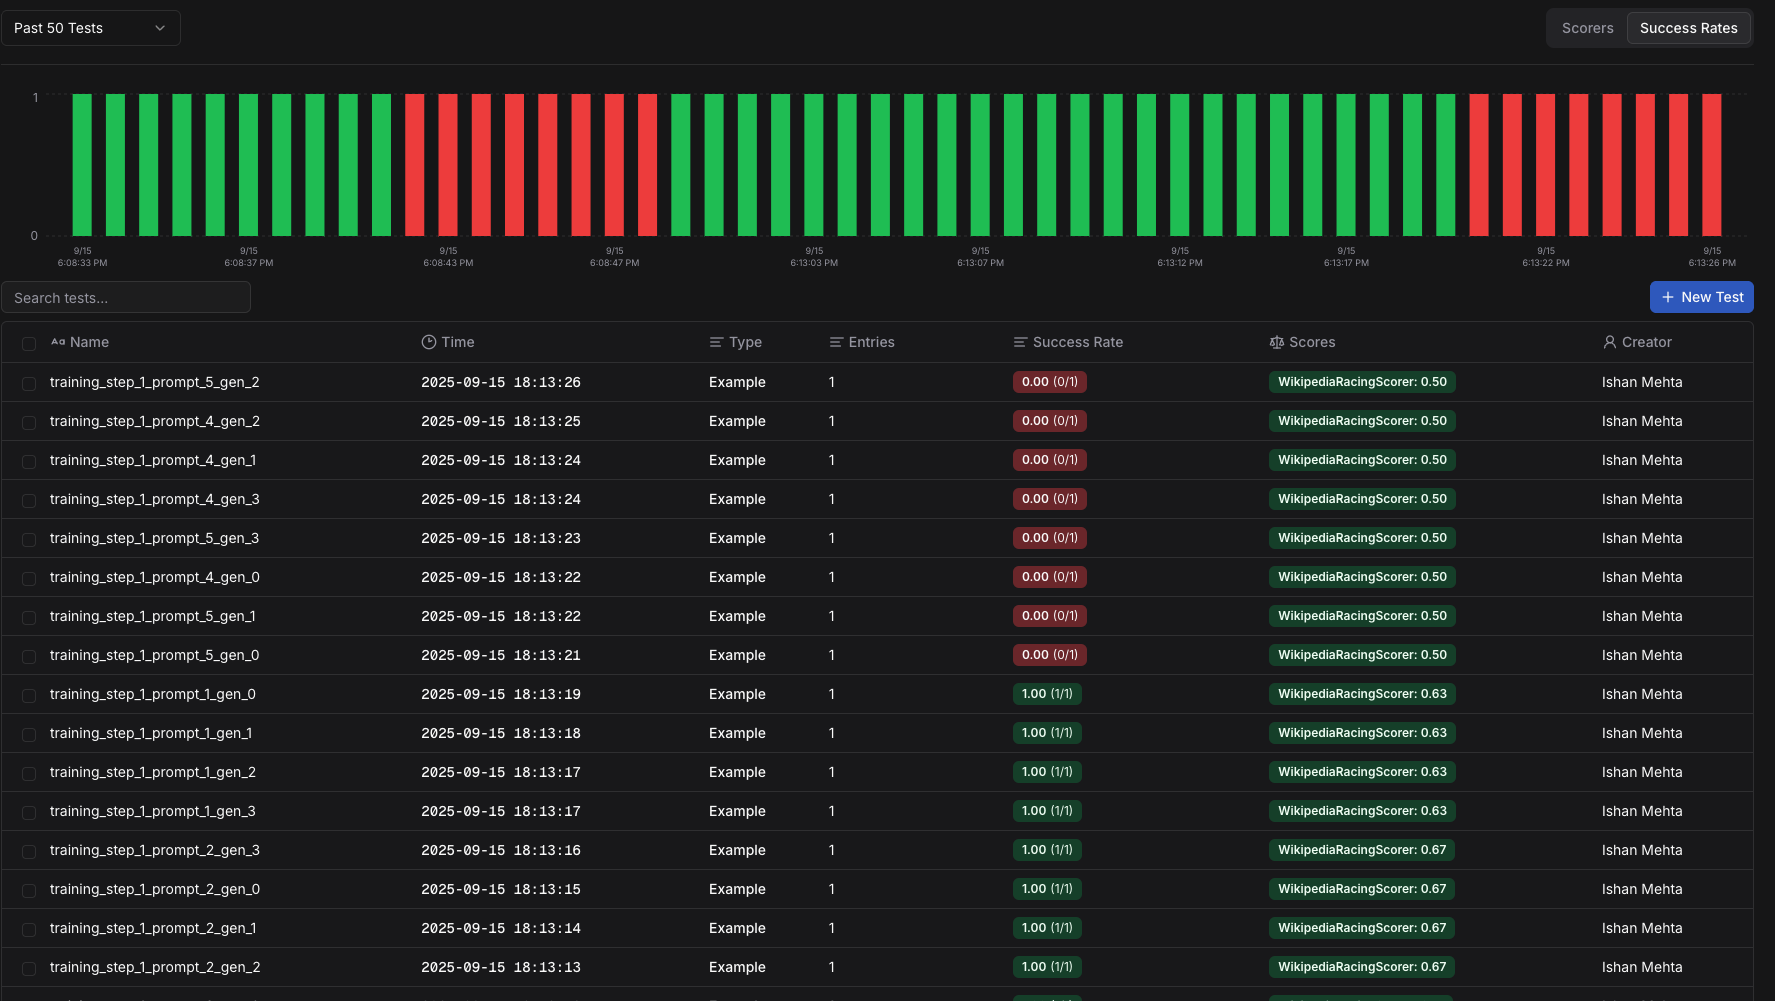

Now, we have our end result of the RFT job! 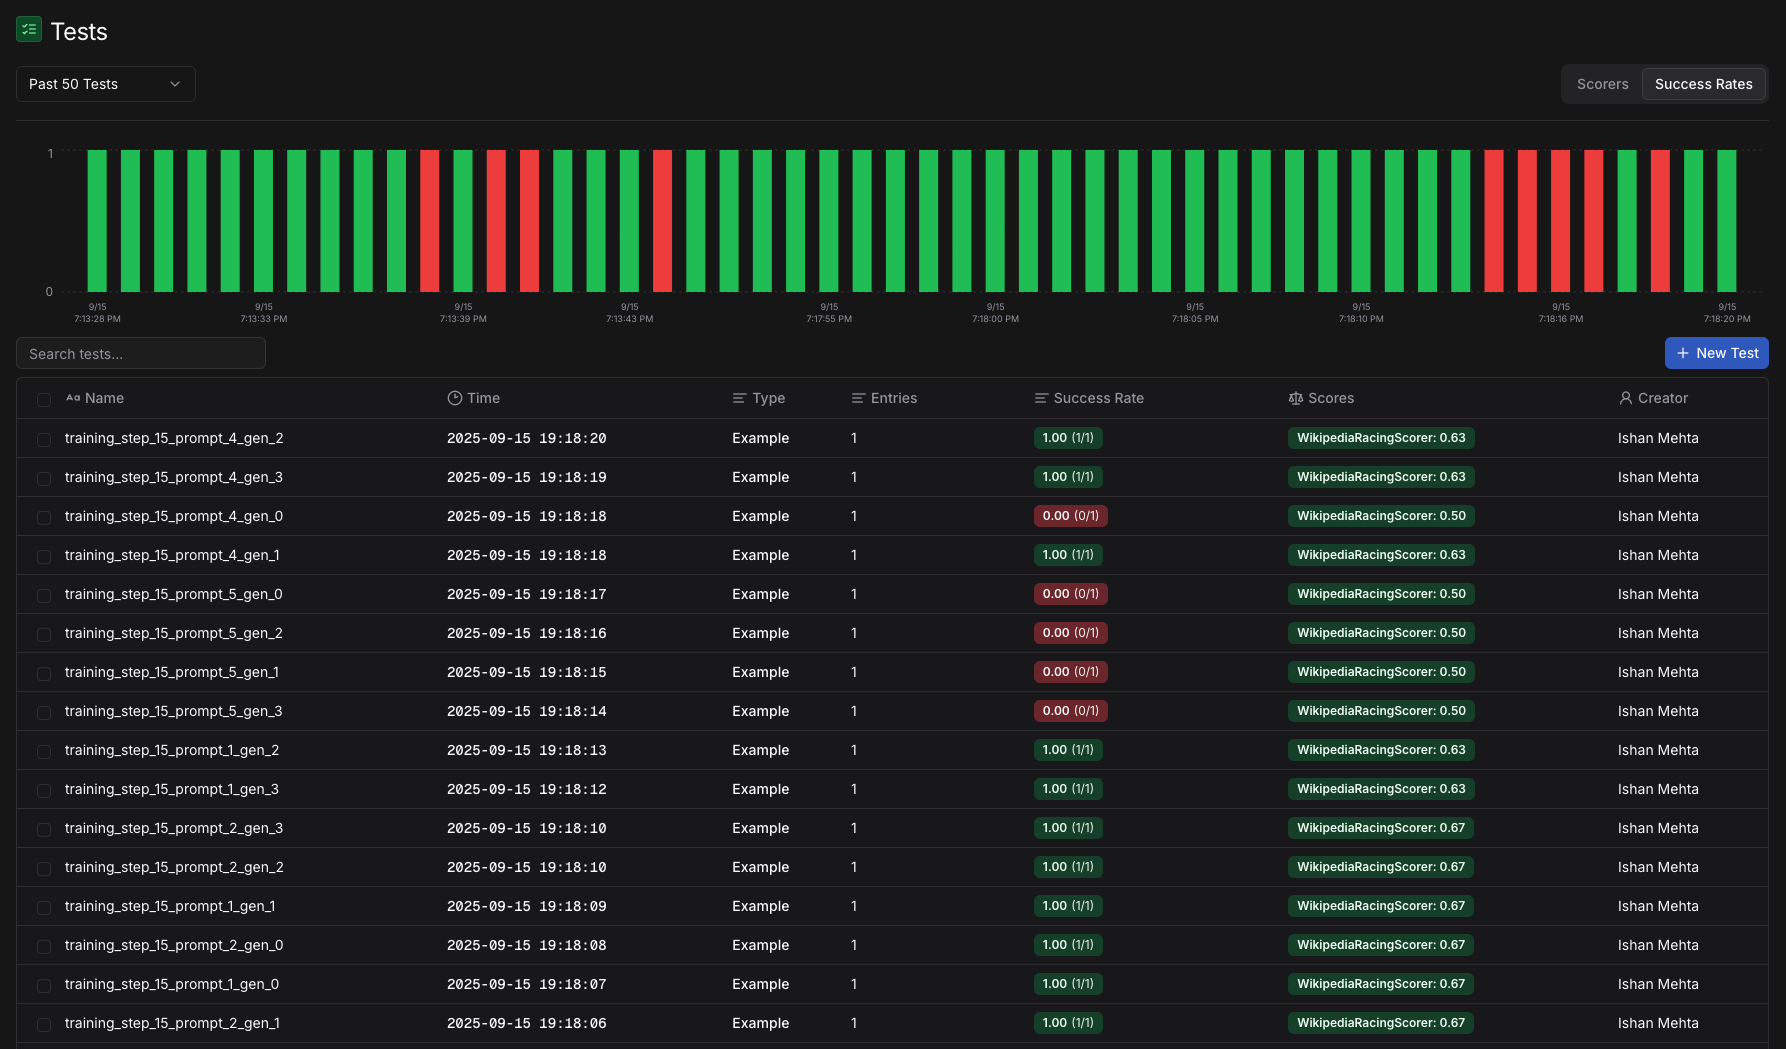

As you can see, there is an accuracy increase from 0% initially to approximately 68% at the beginning of the RFT job to 82% after the RFT!